In [1]:
from dotenv import load_dotenv
from sqlalchemy import create_engine
import earthaccess
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import rasterio
import xarray as xr
import glob

# Set up the path for the .tif files (assuming they follow a naming pattern like 'VNL_v21_npp_2020_global_vcmslcfg.tif')
tif_directory = '../scripts/NTL/'  # Directory where .tif files are stored
tif_pattern = "VNL_v21_npp_*_global_vcmslcfg_c202205302300.average_masked.dat.tif"  # Adjust this to match filenames

# Get all the .tif filenames in the directory
tif_files = glob.glob(os.path.join(tif_directory, tif_pattern))

# Define downsampling factor
downsample_factor = 7

# Function to process each year/tif file
def process_radiance_file(tif_path, year):
    with rasterio.open(tif_path) as src:
        # Read the first band data, applying the downsampling factor
        data = src.read(1)[::downsample_factor, ::downsample_factor]  # Downsample by selecting every nth pixel
        transform = src.transform  # Get the affine transform for geolocation

    # Get the dimensions of the downsampled raster
    rows, cols = data.shape

    # Create arrays of row and column indices for the downsampled data
    row_indices, col_indices = np.indices((rows, cols))

    # Adjust the transform for downsampling to map geographical coordinates correctly
    downsampled_transform = transform * rasterio.Affine.scale(downsample_factor)

    # Convert row/col indices to geographical coordinates based on the downsampled transform
    lon, lat = rasterio.transform.xy(downsampled_transform, row_indices, col_indices)

    # Flatten the arrays and create a DataFrame
    df = pd.DataFrame({
        'longitude': np.array(lon).flatten(),
        'latitude': np.array(lat).flatten(),
        'radiance': data.flatten()  # Flatten the data array
    })

    # Define the function to align to the existing grid
    def round_to_grid(value, start, step):
        """Round to nearest grid point with given start and step."""
        return np.round((value - start) / step) * step + start

    # Apply custom rounding to latitude and longitude to align with Earthdata grid
    df['lon'] = df['longitude'].apply(lambda x: round_to_grid(x, -179.875, 0.25)) 
    df['lat'] = df['latitude'].apply(lambda x: round_to_grid(x, -65.125, 0.25))  # Starting latitude adjusted to -65.125

    # Group by the new rounded lat and lon, then calculate the mean radiance
    df_rescaled = df.groupby(['lat', 'lon'], as_index=False)['radiance'].mean()

    # Save the rescaled DataFrame to a new CSV with the year
    csv_rescaled_filename = f'radiance_{year}.csv'
    df_rescaled.to_csv(csv_rescaled_filename, index=False)

    print(f"Data for year {year} rescaled and saved to {csv_rescaled_filename}.")

# Loop through all the tif files and process them
total_files = len(tif_files)
for index, tif_file in enumerate(tif_files, start=1):
    # Extract the year based on filename pattern
    year = tif_file.split('_')[3]  # Adjusted index to get the correct year from the filename
    
    print(f"\nProcessing {tif_file} for year {year}...")

    # Step 1: Process the radiance data from the .tif file
    process_radiance_file(tif_file, year)
    
    # Print a percentage for the progress
    percent_done = (index / total_files) * 100
    print(f"Progress: {percent_done:.2f}%")

print("\nAll files processed successfully!")



Processing ../scripts/NTL\VNL_v21_npp_2014_global_vcmslcfg_c202205302300.average_masked.dat.tif for year 2014...
Data for year 2014 rescaled and saved to radiance_2014.csv.
Progress: 16.67%

Processing ../scripts/NTL\VNL_v21_npp_2015_global_vcmslcfg_c202205302300.average_masked.dat.tif for year 2015...
Data for year 2015 rescaled and saved to radiance_2015.csv.
Progress: 33.33%

Processing ../scripts/NTL\VNL_v21_npp_2016_global_vcmslcfg_c202205302300.average_masked.dat.tif for year 2016...
Data for year 2016 rescaled and saved to radiance_2016.csv.
Progress: 50.00%

Processing ../scripts/NTL\VNL_v21_npp_2017_global_vcmslcfg_c202205302300.average_masked.dat.tif for year 2017...
Data for year 2017 rescaled and saved to radiance_2017.csv.
Progress: 66.67%

Processing ../scripts/NTL\VNL_v21_npp_2018_global_vcmslcfg_c202205302300.average_masked.dat.tif for year 2018...
Data for year 2018 rescaled and saved to radiance_2018.csv.
Progress: 83.33%

Processing ../scripts/NTL\VNL_v21_npp_2019_g

RasterioIOError: VNL_v21_npp_2019_global_vcmslcfg_c202205302300.average_masked.dat.tif: TIFFReadDirectory:Failed to read directory at offset 11612640020

In [2]:
import matplotlib.pyplot as plt

# Set the figure background color to black
plt.figure(figsize=(48, 32), facecolor='white')

# Scatter plot with color based on radiance, fixed color scale from 0 to 1
scatter = plt.scatter(df_filtered['lon'], df_filtered['lat'], c=df_filtered['radiance'], cmap='plasma', s=2, vmin=0, vmax=1)

# Add color bar to indicate radiance levels
plt.colorbar(scatter, label='Radiance')

# Add labels and title with white text
plt.title('Radiance Based on Latitude and Longitude', color='white')
plt.xlabel('Longitude', color='white')
plt.ylabel('Latitude', color='white')

# Set the axis background color to black and the grid color to white for visibility
plt.gca().set_facecolor('#1a1a1a')
plt.grid(True, color='white')

# Change tick labels color to white for better visibility on black background
plt.tick_params(axis='both', colors='white')

# Display the plot
plt.show()



NameError: name 'df_filtered' is not defined

<Figure size 4800x3200 with 0 Axes>

# Might need to recreate the Downscaling to fit the values in the earthdata tables

MemoryError: Unable to allocate 2.70 GiB for an array with shape (33601, 86401) and data type bool

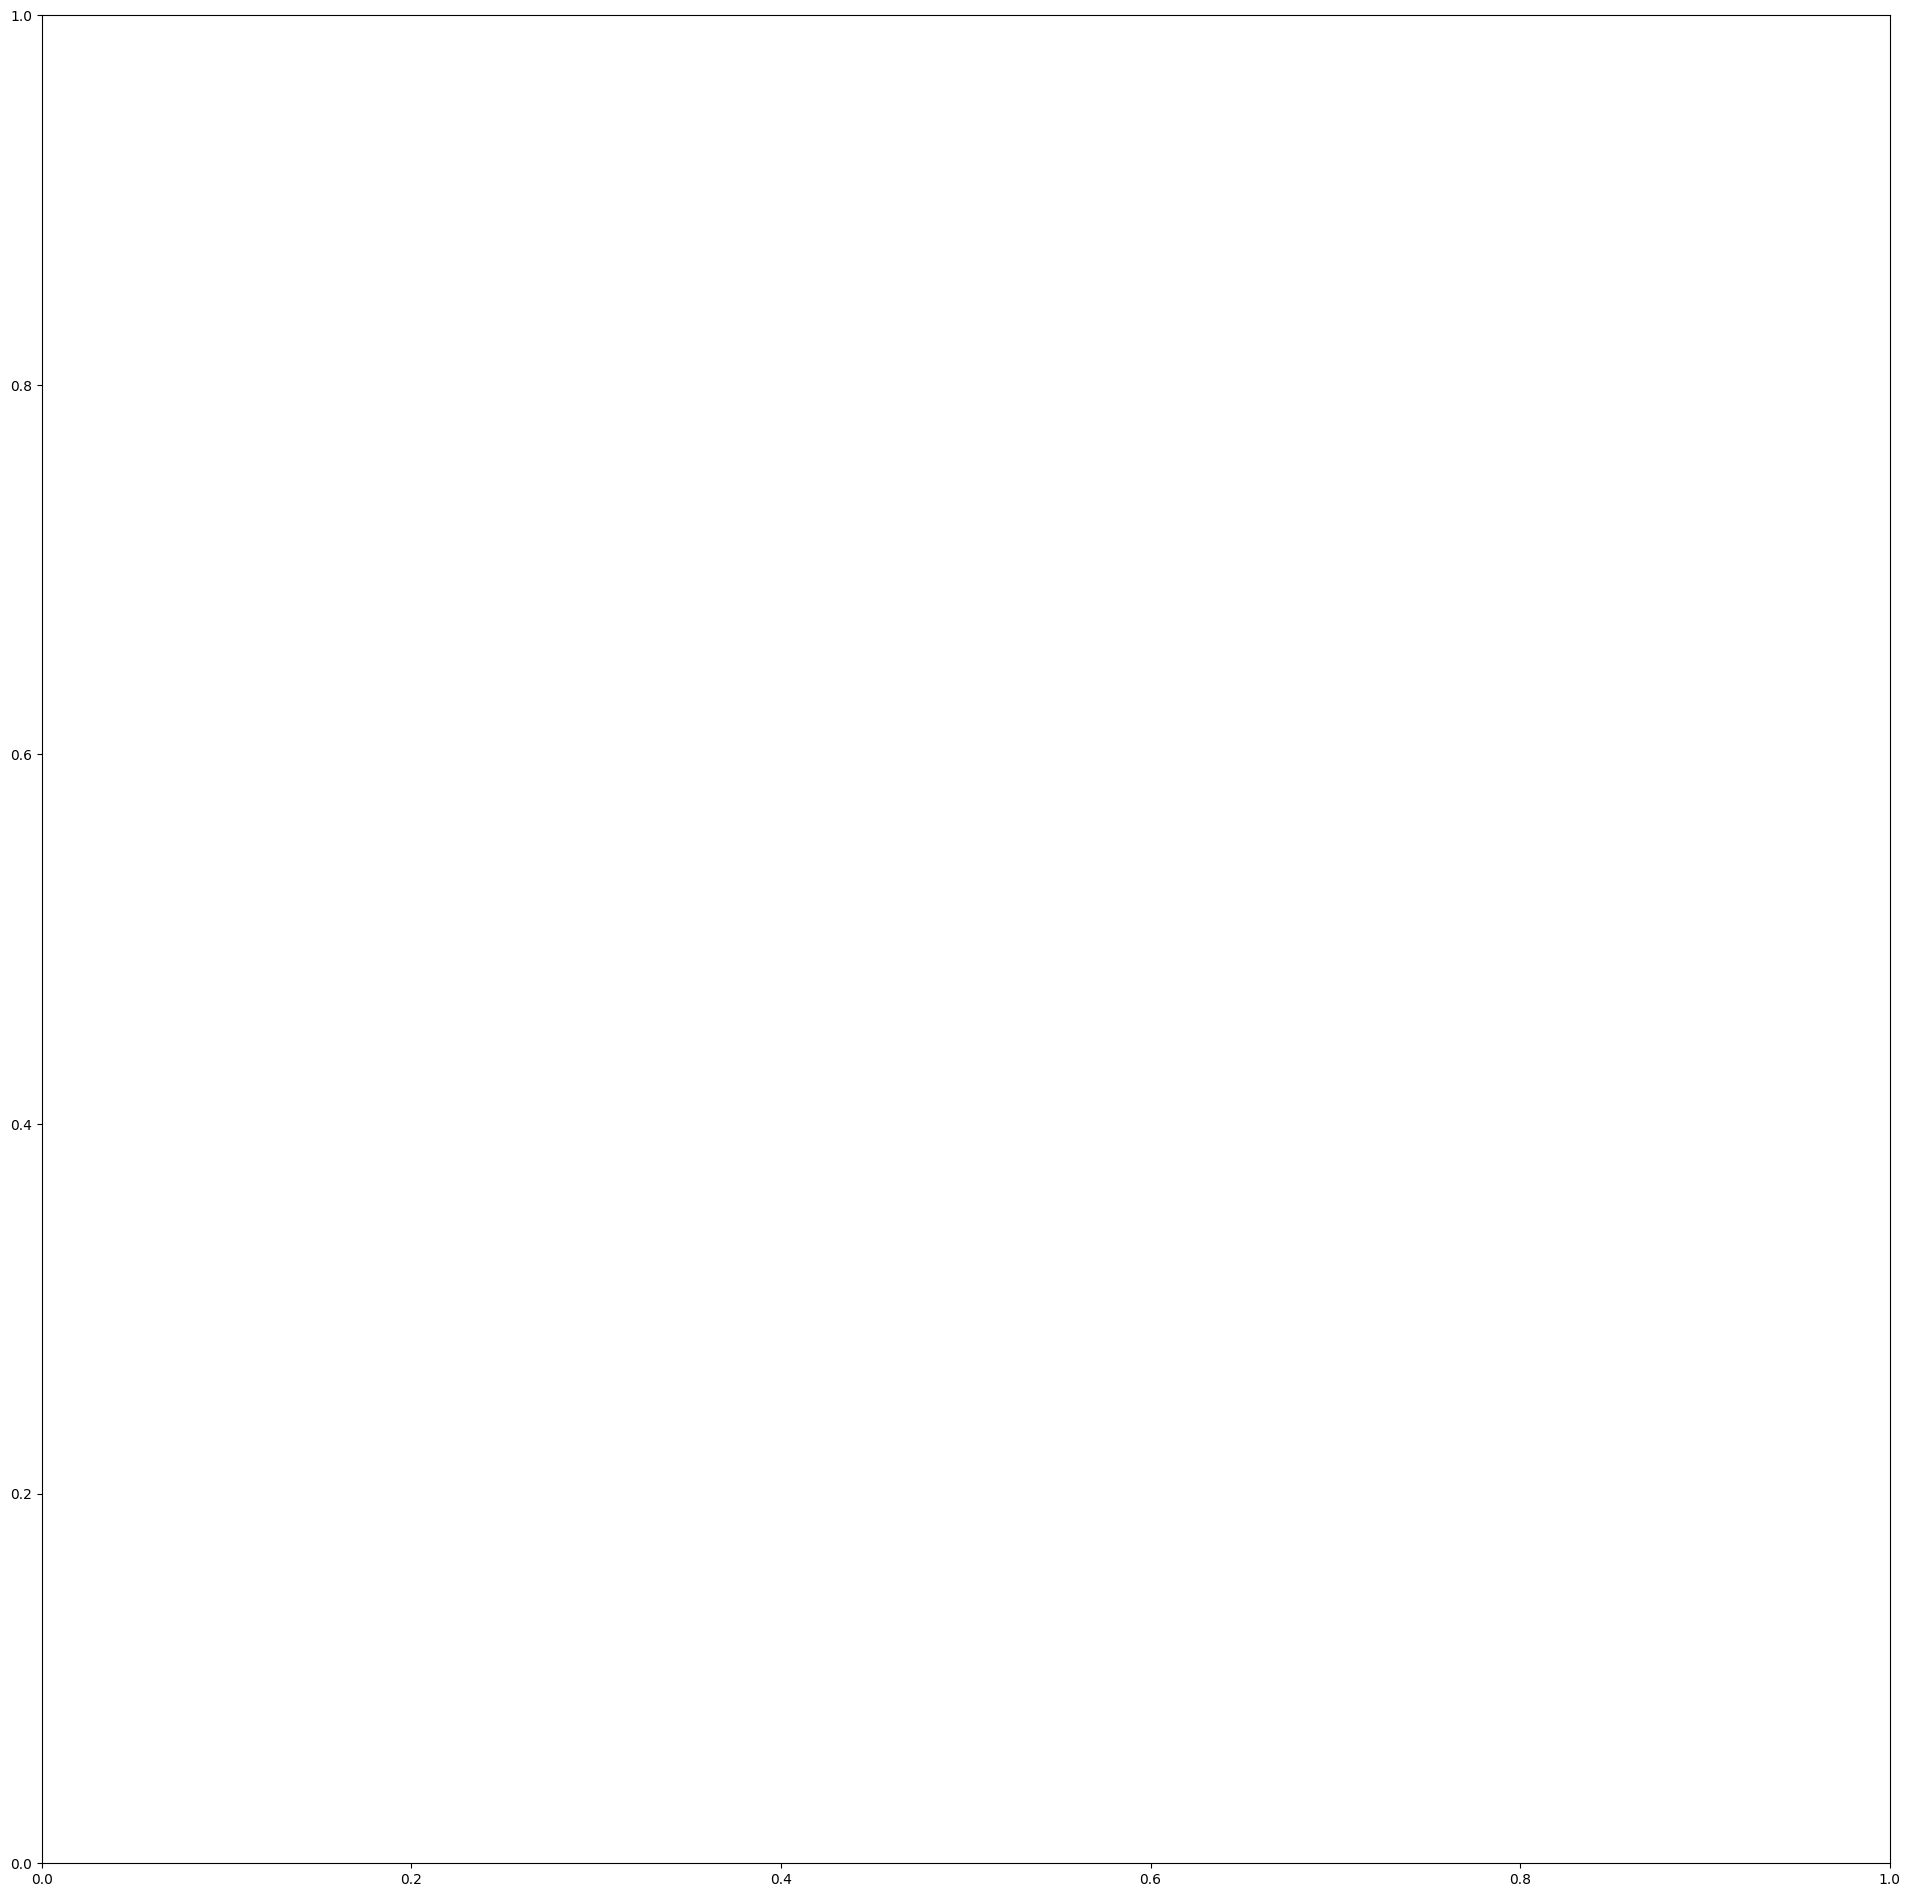

In [ ]:
df = pd.read_csv("rescaled_radiance_data.csv")

# Create a scatter plot of radiance values based on longitude and latitude
plt.figure(figsize=(48, 24))
plt.imshow(data, cmap='viridis', vmin=0, vmax=1)  # Set vmin and vmax based on expected data range
plt.scatter(df['rounded_longitude'], df['rounded_latitude'], c=df['radiance'], cmap='viridis', s=0.1, alpha=0.5)  # Reduced point size
plt.colorbar(label='Radiance')
plt.title('Nighttime VIIRS Radiance 2020 (Downsampled)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()
plt.show()

# **Optional: Try to create an Earthaccess pipeline** #

In [ ]:
# Import required libraries
import earthaccess
import xarray as xr

# Define test parameters
auth = earthaccess.login()
doi_code = "10.5067/VIIRS/VNP46A4.001"  # Assuming this is the DOI for the yearly dataset
short_name = "VNP46A4"
bounding_box = (-180, -90, 180, 90)

# Test for a single date
year = 2012
start_date = f"{year}-01-01"

try:
    # Search for data for the specified date
    results = earthaccess.search_data(
        doi=doi_code,
        temporal=(start_date, start_date),
        bounding_box=bounding_box,
        short_name=short_name
    )
    
    fs = earthaccess.open(results)

    # Test loading one file to inspect its structure
    test_file = fs[0]  # Pick the first file to check
    ds = xr.open_dataset(test_file)

    # Print dataset structure for inspection
    print("Dataset structure:")
    print(ds)

    # Process only if dimensions are suitable
    if 'latitude' in ds.dims and 'longitude' in ds.dims:
        var_name = 'YourMainVariable'  # Replace with the main variable of interest in your dataset
        var_df = ds[var_name].to_dataframe().reset_index()

        # Aggregate and save a small sample
        aggregated_df = var_df.groupby(['longitude', 'latitude']).agg(
            min_value=(var_name, 'min'),
            max_value=(var_name, 'max'),
            avg_value=(var_name, 'mean')
        ).reset_index()

        # Save to CSV for inspection
        csv_filename = f"earthdata_{year}_test.csv"
        aggregated_df.to_csv(csv_filename, index=False)
        print(f"Test data saved to {csv_filename}")
    else:
        print("The dataset lacks expected dimensions (lat/lon). Check dataset structure.")

except Exception as e:
    print(f"An error occurred during the test: {e}")
